Based on the course _Elements of Data Science_ from the [AWS Certified Machine Learning](https://aws.amazon.com/training/learning-paths/machine-learning/) program and [The Interactive Data Science Tutorial](https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial), this notebook summarizes the ML workflow and provides a template as a starting guide to a new project.

Imports

In [1]:
# data analysis and wrangling
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import Imputer

# visualization
from viz import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset loading

As toy example we will use the famous Titanic dataset from Kaggle.

For a description on the meaning of the columns go to https://www.kaggle.com/c/titanic/data

In [2]:
train_df = pd.read_csv('./data/titanic/train.csv')
test_df = pd.read_csv('./data/titanic/test.csv')

full = train_df.append(test_df, ignore_index = True)
titanic = train_df

# Data preprocessing and Feature Engineering

1. Categorical (aka discrete) variables need to be encoded, e.g. $color \in{\{green, red, blue\}}$, algorithms require numericals.
1. Handle missing values; most ML algorithms require all variables to have values.

## Encoding

Ordinal values can be mapped to integers.  
**Example** if we know L (large) > M > S, then { S: 5, M: 10, L: 20 } might work.

To encode labels (predictor) variables, we can use LabelEncoder.  
**Note** that this is only good for binary categories.  
**Example**, on a dataset of house pricing, we'd have a label _loan_approved_ be either 'Y' or 'N', and transform it to 1 or 0.

In [3]:
full.Sex.value_counts()

male      843
female    466
Name: Sex, dtype: int64

In [4]:
# This is old-school but here we encode sex as binary value
sex = pd.Series(np.where(full.Sex == 'male', 1, 0), name='Sex')
sex.value_counts()

1    843
0    466
Name: Sex, dtype: int64

### Encoding nominals

Encoding nominals is a different story. Here ordering and size is meaningless.
Rather use _one-hot encoding_, which will explode the feature into binary attributes.

**Tip**: when encoding with many classes, we can simplify by defining a hierarchy or grouping by similarity, e.g. regions -> states -> cities.

In [5]:
full[['Embarked', 'Pclass']].head()

,Embarked,Pclass
0,S,3
1,C,1
2,S,3
3,S,1
4,S,3


In [6]:
embarked = pd.get_dummies(full.Embarked, prefix='Embarked')
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [7]:
pclass = pd.get_dummies(full.Pclass, prefix='Pclass')
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


### Update columns

In [8]:
full.Sex = sex
full = pd.concat([full, embarked, pclass], axis=1)
full.drop(['Embarked', 'Pclass'], axis=1, inplace=True)

,Age,Cabin,Fare,Name,Parch,PassengerId,Sex,SibSp,Survived,Ticket,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",0,1,1,1,0.0,A/5 21171,0,0,1,0,0,1
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,0,1,1.0,PC 17599,1,0,0,1,0,0
2,26.0,NaN,7.9250,"Heikkinen, Miss. Laina",0,3,0,0,1.0,STON/O2. 3101282,0,0,1,0,0,1
3,35.0,C123,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,0,1,1.0,113803,0,0,1,1,0,0
4,35.0,NaN,8.0500,"Allen, Mr. William Henry",0,5,1,0,0.0,373450,0,0,1,0,0,1
5,NaN,NaN,8.4583,"Moran, Mr. James",0,6,1,0,0.0,330877,0,1,0,0,0,1
6,54.0,E46,51.8625,"McCarthy, Mr. Timothy J",0,7,1,0,0.0,17463,0,0,1,1,0,0
7,2.0,NaN,21.0750,"Palsson, Master. Gosta Leonard",1,8,1,3,0.0,349909,0,0,1,0,0,1
8,27.0,NaN,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,0,0,1.0,347742,0,0,1,0,0,1
9,14.0,NaN,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,0,1,1.0,237736,1,0,0,0,1,0


## Handle missing values

1. Use `df.isnull().sum()` to see number of missing values per feature.
2. Use `df.dropna()` to drop rows with NULL values, pass axis=1 to drop columns.
3. Fill values using `df.fillna`.
4. Use an Imputer.

**Important**: Droping incomplete rows or columns might risk losing too much data, introducing bias/overfitting, etc...

_Are these values missing at random?_

Imputation is the process of replacing with mean, median, or most frequent value (for categoricals). See MICEImputer and fancyimpute.

In [9]:
print('total', full.shape[0])
full.isnull().sum()

total 1309


Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
Pclass_1          0
Pclass_2          0
Pclass_3          0
dtype: int64

### Missing cabin

In [10]:
print('rows with no Cabin entry {0:.0%}'.format(full.Cabin.isnull().sum() / full.shape[0]))

rows with no Cabin entry 77%


The % of missing entries is so large that by imputing there's a risk of introducing bias or a weird artifact to the model.

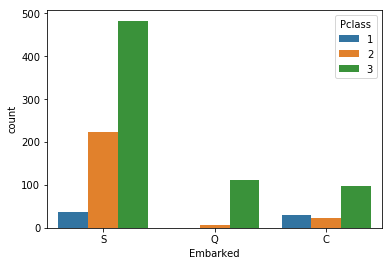

In [11]:
without_cabin = full[full.Cabin.isnull()]
sns.countplot(x="Embarked", hue="Pclass", data=without_cabin)

In [12]:
full.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

Do we see less survival on people with no cabin assigned? Or is it that the cabin assignment is not complete in the dataset (perhaps lost with the sinking ship)?

/home/ro/anaconda2/envs/deep/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


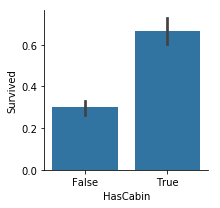

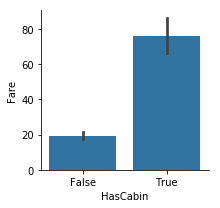

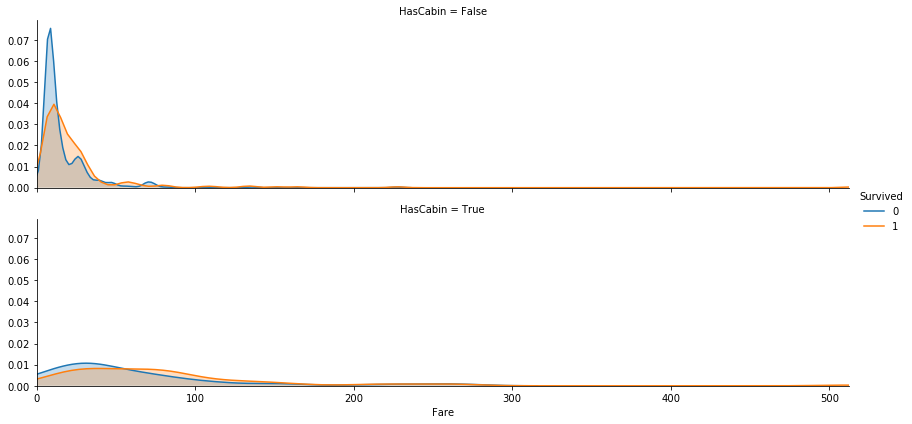

In [13]:
temporal = titanic.copy()
temporal['HasCabin'] = temporal.Cabin.notnull()
plot_categories(temporal, cat='HasCabin', target='Survived')
plot_categories(temporal, cat='HasCabin', target='Fare')
plot_distribution(temporal, var='Fare', target='Survived', row='HasCabin')

I see two options:
1. Either we drop `Cabin` to avoid risking the model, as I'm not completely sure if that 77% missing data is due to an external event.
2. Or we fill `Cabin` with Unknown, as it seems highly correlated to the fare ticket.

Let's keep the `Cabin` for now.

In [14]:
full.Cabin.fillna('U', inplace=True)
full.isnull().sum()

Age            263
Cabin            0
Embarked         2
Fare             1
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Pclass_1         0
Pclass_2         0
Pclass_3         0
dtype: int64

#### Introducing sklearn Imputer

In [15]:
full.Fare.value_counts().head()

8.0500     60
13.0000    59
7.7500     55
26.0000    50
7.8958     49
Name: Fare, dtype: int64

In [16]:
full[full.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
1043,60.5,U,S,NaN,"Storey, Mr. Thomas",0,1044,3,1,0,NaN,3701,0,0,1,0,0,1


In [17]:
# Note: it will only work with numerical

imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=1, copy=False)
imputed_columns = imputer.fit_transform(full[['Fare', 'SibSp']])
imputed_columns

array([[  7.25  ,   1.    ],
       [ 71.2833,   1.    ],
       [  7.925 ,   0.    ],
       ..., 
       [  7.25  ,   0.    ],
       [  8.05  ,   0.    ],
       [ 22.3583,   1.    ]])

In [18]:
full.Fare.value_counts().head()

8.0500     60
13.0000    59
7.7500     55
26.0000    50
7.8958     49
Name: Fare, dtype: int64

In [19]:
full.iloc[[1043]]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
1043,60.5,U,S,NaN,"Storey, Mr. Thomas",0,1044,3,1,0,NaN,3701,0,0,1,0,0,1


If imputer doesn't work, just use pandas

In [20]:
full.Fare.fillna(full.Fare.mean(), inplace=True)

#### You can use pandas fillna too

Let's round up the mean age, and use it to fill in missing values.

In [21]:
full[full.Age.isnull()].head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
5,NaN,U,Q,8.4583,"Moran, Mr. James",0,6,3,1,0,0.0,330877,0,1,0,0,0,1
17,NaN,U,S,13.0000,"Williams, Mr. Charles Eugene",0,18,2,1,0,1.0,244373,0,0,1,0,1,0
19,NaN,U,C,7.2250,"Masselmani, Mrs. Fatima",0,20,3,0,0,1.0,2649,1,0,0,0,0,1
26,NaN,U,C,7.2250,"Emir, Mr. Farred Chehab",0,27,3,1,0,0.0,2631,1,0,0,0,0,1
28,NaN,U,Q,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,29,3,0,0,1.0,330959,0,1,0,0,0,1


In [22]:
age_mean = round(full.Age.mean())
full.Age.fillna(age_mean, inplace=True)

full.iloc[[5, 17, 19, 26, 28]]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
5,30.0,U,Q,8.4583,"Moran, Mr. James",0,6,3,1,0,0.0,330877,0,1,0,0,0,1
17,30.0,U,S,13.0000,"Williams, Mr. Charles Eugene",0,18,2,1,0,1.0,244373,0,0,1,0,1,0
19,30.0,U,C,7.2250,"Masselmani, Mrs. Fatima",0,20,3,0,0,1.0,2649,1,0,0,0,0,1
26,30.0,U,C,7.2250,"Emir, Mr. Farred Chehab",0,27,3,1,0,0.0,2631,1,0,0,0,0,1
28,30.0,U,Q,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,29,3,0,0,1.0,330959,0,1,0,0,0,1


Fill the missing Embarked fields with the most popular value 'S'.

In [23]:
full[full.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,0,0,1.0,113572,0,0,0,1,0,0
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,0,0,1.0,113572,0,0,0,1,0,0


In [24]:
most_frequent = full.Embarked.mode()[0]
full.Embarked.fillna(most_frequent, inplace=True)

In [25]:
full.isnull().sum()

Age              0
Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Pclass_1         0
Pclass_2         0
Pclass_3         0
dtype: int64

#### Splitting preprocessed training and testing sets

In [26]:
train = full[full.Survived.notnull()]
test = full[full.Survived.isnull()]

train.isnull().sum()

Age            0
Cabin          0
Embarked       0
Fare           0
Name           0
Parch          0
PassengerId    0
Pclass         0
Sex            0
SibSp          0
Survived       0
Ticket         0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Pclass_1       0
Pclass_2       0
Pclass_3       0
dtype: int64

Don't mind the missing values for Survived, those come from the test dataset.

## Exporting data

Using pickles we can save our changes for the next notebook

In [27]:
with open('data/titanic_preprocessed.pkl', 'wb') as handle:
    pickle.dump(full, handle, protocol=pickle.HIGHEST_PROTOCOL)